## Clean de ventas
limpiando outliers e imputando


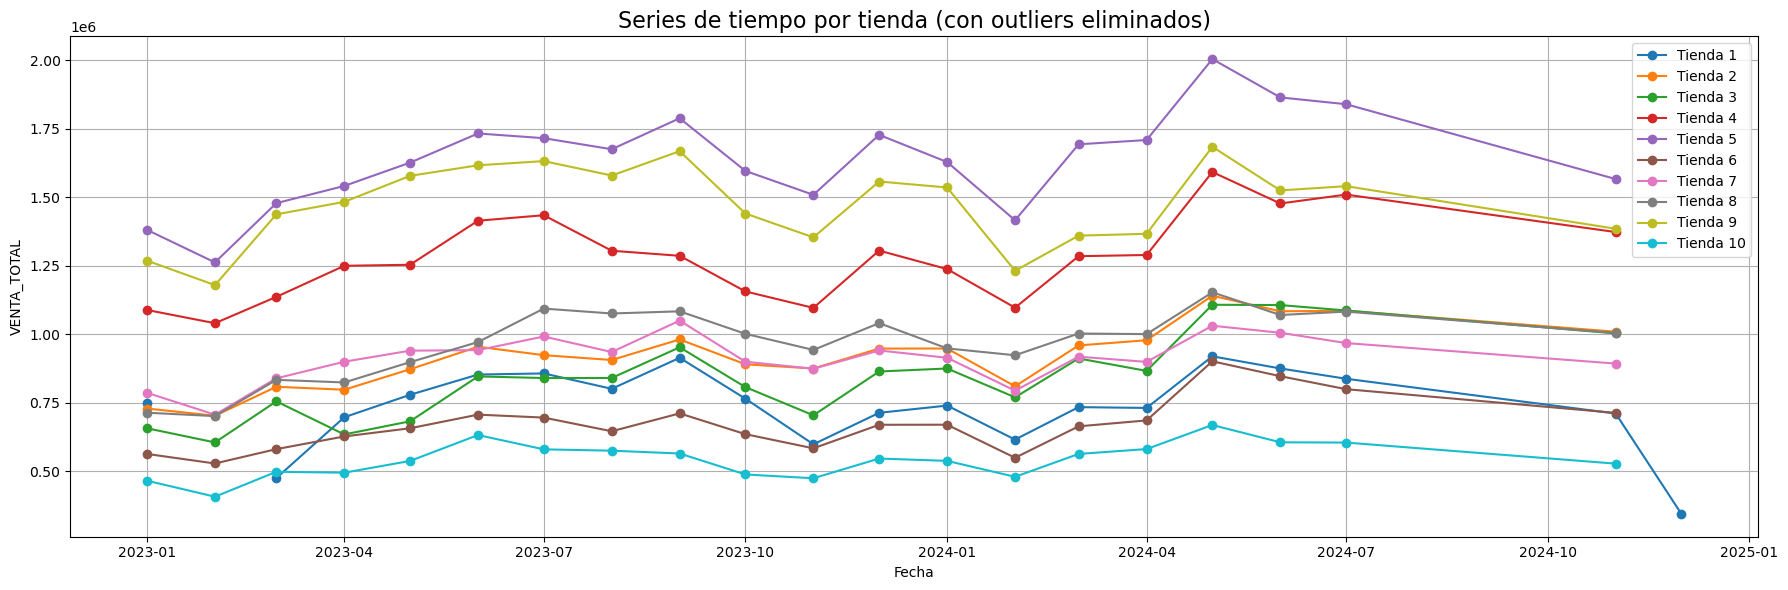

,TIENDA_ID,mean,std,lower_bound,outliers_count
0,1,7.080276e+05,188238.639493,3.315503e+05,1
1,2,8.994741e+05,147170.438997,6.051333e+05,1
2,3,8.274871e+05,170336.714410,4.868137e+05,1
3,4,1.247370e+06,215367.969433,8.166343e+05,1
4,5,1.596267e+06,256352.799184,1.083561e+06,1
...,...,...,...,...,...
95,96,1.413160e+06,245624.492635,9.219110e+05,1
96,97,9.087342e+05,133756.406223,6.412214e+05,1
97,98,1.408476e+06,363790.800825,6.808942e+05,1
98,99,1.145038e+06,226994.290486,6.910490e+05,1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Cargar y formatear datos como time series por tienda ---
df = pd.read_csv("Venta.csv")
df.sort_values(by=['TIENDA_ID', 'MES_ID'], inplace=True)

# Convertir MES_ID a datetime
df['MES_ID'] = pd.to_datetime(df['MES_ID'].astype(str), format='%Y%m')

# Crear tabla pivote con fechas como filas, tiendas como columnas
df_pivot = df.pivot(index='MES_ID', columns='TIENDA_ID', values='VENTA_TOTAL')

# --- 2. Detectar outliers por tienda (media - 2*std) ---
outliers_summary = []

def detect_outliers(series):
    mean = series.mean()
    std = series.std()
    lower_bound = mean - 2 * std
    outlier_mask = series < lower_bound
    outliers_summary.append({
        'TIENDA_ID': series.name,
        'mean': mean,
        'std': std,
        'lower_bound': lower_bound,
        'outliers_count': outlier_mask.sum()
    })
    return outlier_mask

outliers_mask_df = df_pivot.apply(detect_outliers)

# --- 3. Reemplazar outliers con NaN ---
df_cleaned = df_pivot.mask(outliers_mask_df)

# --- 4. Visualización en formato time series tradicional ---
fig, ax = plt.subplots(figsize=(18, 6))

# Graficar algunas tiendas como ejemplo
for tienda_id in df_cleaned.columns[:10]:
    ax.plot(df_cleaned.index, df_cleaned[tienda_id], label=f'Tienda {tienda_id}', marker='o')

ax.set_title('Series de tiempo por tienda (con outliers eliminados)', fontsize=16)
ax.set_xlabel('Fecha')
ax.set_ylabel('VENTA_TOTAL')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# Crear resumen tabular
outlier_stats_df = pd.DataFrame(outliers_summary)
outlier_stats_df.head(100)


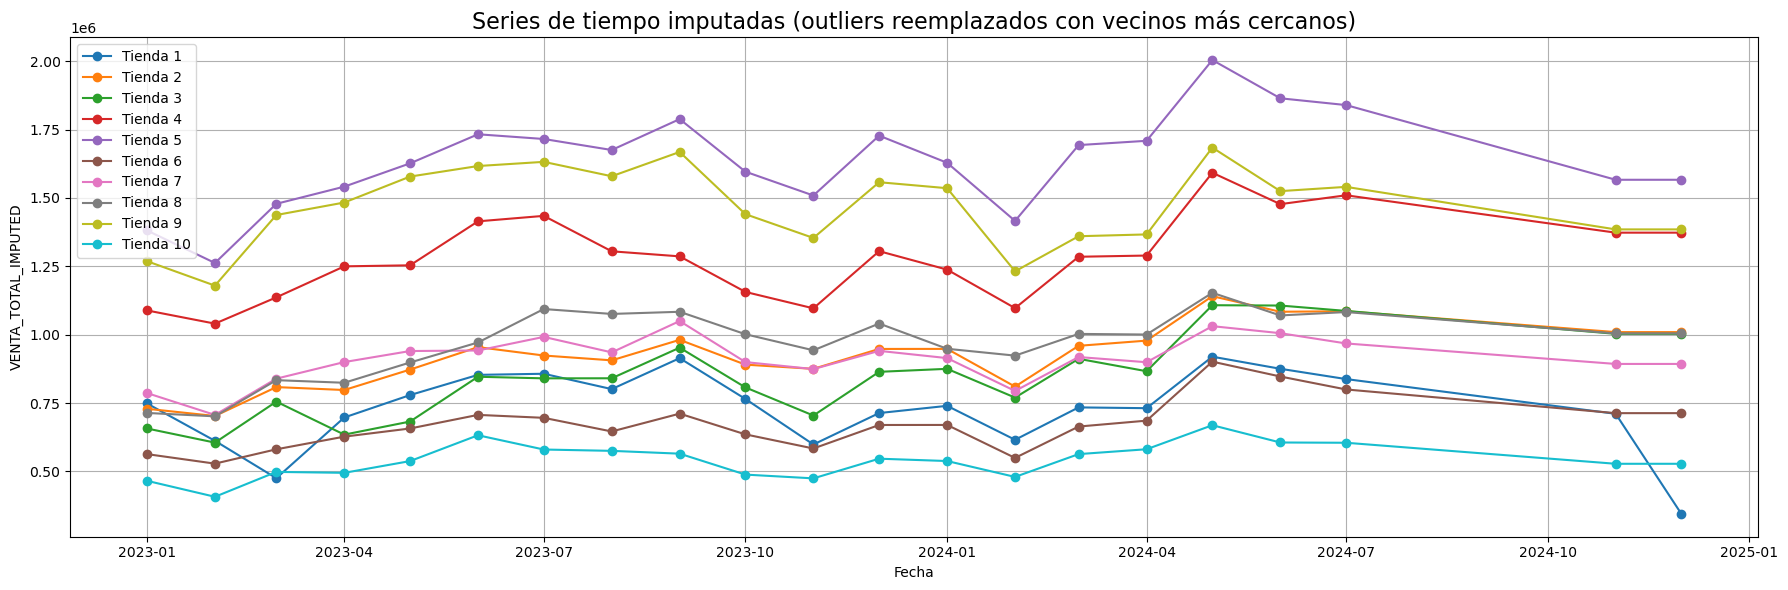

In [3]:
# --- 5. Imputar los outliers con el promedio de vecinos válidos más cercanos ---
def impute_with_neighbors(series, mask):
    s = series.copy()
    for idx in s[mask].index:
        prev_idx = s[:idx][~mask[:idx]].last_valid_index()
        next_idx = s[idx:][~mask[idx:]].first_valid_index()
        prev_val = s[prev_idx] if prev_idx is not None else np.nan
        next_val = s[next_idx] if next_idx is not None else np.nan
        s.loc[idx] = np.nanmean([prev_val, next_val])
    return s

# Aplicar la imputación por tienda
df_imputed = pd.DataFrame({
    col: impute_with_neighbors(df_pivot[col], outliers_mask_df[col])
    for col in df_pivot.columns
})

# --- 6. Visualización comparativa ---
fig, ax = plt.subplots(figsize=(18, 6))

for tienda_id in df_imputed.columns[:10]:
    ax.plot(df_imputed.index, df_imputed[tienda_id], label=f'Tienda {tienda_id}', marker='o')

ax.set_title('Series de tiempo imputadas (outliers reemplazados con vecinos más cercanos)', fontsize=16)
ax.set_xlabel('Fecha')
ax.set_ylabel('VENTA_TOTAL_IMPUTED')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# Mostrar primeros valores imputados como verificación
df_imputed.head()
ventas_clean = df_imputed.copy()
ventas_clean.to_csv('ventas_clean.csv', index=True)



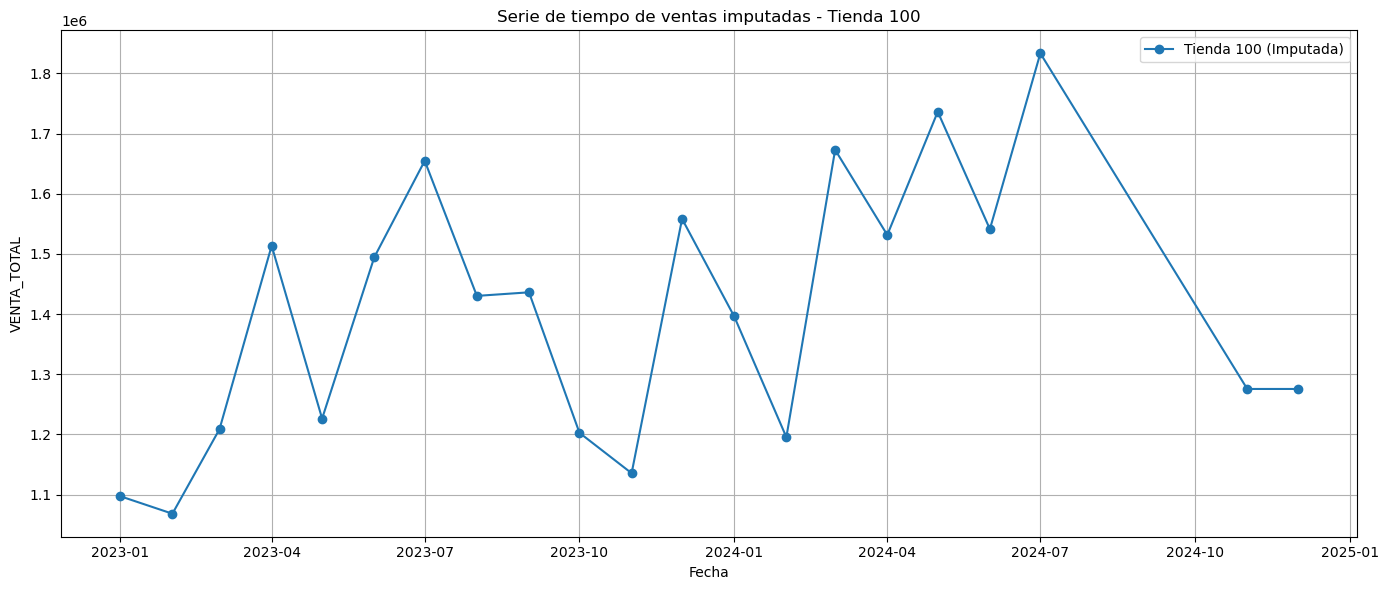

In [4]:
# Graficar la serie de tiempo imputada para una tienda específica (por ejemplo, tienda 1)
tienda_id = 100 # puedes cambiar este ID por el que desees visualizar

plt.figure(figsize=(14, 6))
plt.plot(ventas_clean.index, ventas_clean[tienda_id], label=f'Tienda {tienda_id} (Imputada)', marker='o')
plt.title(f'Serie de tiempo de ventas imputadas - Tienda {tienda_id}')
plt.xlabel('Fecha')
plt.ylabel('VENTA_TOTAL')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


missing values

In [5]:
# Número total de NaN en todo el DataFrame
total_nans = ventas_clean.isna().sum().sum()
print(f"Total de NaN restantes: {total_nans}")

# Conteo de NaN por columna (tienda)
nans_por_tienda = ventas_clean.isna().sum()
print(nans_por_tienda[nans_por_tienda > 0])


Total de NaN restantes: 732
20      2
53      1
113     1
146     1
171     1
       ..
874    18
880     3
926     1
962     1
975     1
Length: 83, dtype: int64


In [6]:
ventas_clean = ventas_clean.ffill().bfill()


In [7]:
# 1. Un vistazo rápido al tipo de datos y conteo no-nulos
print(ventas_clean.info())

# 2. Conteo de valores nulos por columna
nulos_por_col = ventas_clean.isna().sum()
print(nulos_por_col[nulos_por_col > 0])

# 3. (Opcional) Porcentaje de nulos por columna
pct_nulos = (ventas_clean.isna().mean() * 100).round(2)
print(pct_nulos[pct_nulos > 0])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 2023-01-01 to 2024-12-01
Columns: 1053 entries, 1 to 1056
dtypes: float64(1053)
memory usage: 173.5 KB
None
Series([], dtype: int64)
Series([], dtype: float64)


In [8]:
# Save the cleaned DataFrame to a CSV file
ventas_clean.to_csv('ventas_cleaned.csv', index=True)
